In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, gc
import math, random
import pickle
import datetime, time
from tqdm import tqdm_notebook as tqdm

import torch 
from torch import nn
from torch import optim

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
#path = '/Users/kanoumotoharu/Downloads/m5-forecasting-accuracy/'
path = '/Users/abcdm/Downloads/m5-forecasting-accuracy/'

In [3]:
os.listdir(path)

['calendar.csv',
 'data_tensor.pickle',
 'sales_train_validation.csv',
 'sample_submission.csv',
 'sell_prices.csv']

In [4]:
%%time
train_df = pd.read_csv(path+'sales_train_validation.csv')
calendar_df = pd.read_csv(path+'calendar.csv')
sell_prices_df = pd.read_csv(path+'sell_prices.csv')
sample_submission_df = pd.read_csv(path+'sample_submission.csv')

Wall time: 4.49 s


In [5]:
gc.collect()

39

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [7]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [8]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [9]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [11]:
sell_prices_df['id'] = sell_prices_df['item_id'].astype('str')+'_'+sell_prices_df['store_id']+'_validation'
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price,id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1_validation
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1_validation
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1_validation
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1_validation
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1_validation


In [12]:
d_cols = [f'd_{i}' for i in range(1,1914)]

In [13]:
event_type_1 = pd.get_dummies(calendar_df.event_type_1)
event_type_1.columns = [f'{col}_event_type_1' for col in event_type_1.columns]
event_type_2 = pd.get_dummies(calendar_df.event_type_1)
event_type_2.columns = [f'{col}_event_type_2' for col in event_type_2.columns]

calendar_data = pd.concat([
    calendar_df.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'])[['wday', 'd','month','snap_CA', 'snap_TX', 'snap_WI']],
    event_type_1,
    event_type_2
], axis=1)

In [14]:
calendar_data.head()

,wday,d,month,snap_CA,snap_TX,snap_WI,Cultural_event_type_1,National_event_type_1,Religious_event_type_1,Sporting_event_type_1,Cultural_event_type_2,National_event_type_2,Religious_event_type_2,Sporting_event_type_2
0,1,d_1,1,0,0,0,0,0,0,0,0,0,0,0
1,2,d_2,1,0,0,0,0,0,0,0,0,0,0,0
2,3,d_3,1,0,0,0,0,0,0,0,0,0,0,0
3,4,d_4,2,1,1,0,0,0,0,0,0,0,0,0
4,5,d_5,2,1,0,1,0,0,0,0,0,0,0,0


In [15]:
calendar_data = calendar_data.set_index('d').T

In [16]:
calendar_data

d,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
wday,1,2,3,4,5,6,7,1,2,3,...,7,1,2,3,4,5,6,7,1,2
month,1,1,1,2,2,2,2,2,2,2,...,6,6,6,6,6,6,6,6,6,6
snap_CA,0,0,0,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
snap_TX,0,0,0,1,0,1,0,1,1,1,...,0,1,1,1,0,1,0,0,0,0
snap_WI,0,0,0,0,1,1,0,1,1,0,...,0,1,1,0,1,1,0,0,0,0
Cultural_event_type_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
National_event_type_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Religious_event_type_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sporting_event_type_1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Cultural_event_type_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
sell_prices_data = sell_prices_df[sell_prices_df.wm_yr_wk.isin(calendar_df.wm_yr_wk.unique())]

In [18]:
sell_prices_data.reset_index(drop=True, inplace=True)

In [19]:
calendar_df.wm_yr_wk.nunique()

282

In [20]:
calendar_df.wm_yr_wk.nunique()

282

In [21]:
sell_prices_data.head()

,store_id,item_id,wm_yr_wk,sell_price,id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1_validation
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1_validation
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1_validation
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1_validation
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1_validation


In [22]:
%%time
tmp = sell_prices_data.groupby(['id'])[['wm_yr_wk', 'sell_price']].apply(lambda x: x.set_index('wm_yr_wk')['sell_price'].to_dict()).to_dict()

Wall time: 12.3 s


In [23]:
d = calendar_df.d
wm_yr_wk = calendar_df.wm_yr_wk

In [24]:
wm_yr_wk.head()

0    11101
1    11101
2    11101
3    11101
4    11101
Name: wm_yr_wk, dtype: int64

In [25]:
price_data = {}
for col in tqdm(train_df.id.unique()):
    price_data[col] = wm_yr_wk.map(tmp[col])

In [26]:
del tmp

In [27]:
price_data = pd.DataFrame(price_data)

In [28]:
price_data.index = d

In [29]:
price_data.head()

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
d,,,,,,,,,,,,,,,,,,,,,
d_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.5,2.47,4.0,NaN,NaN
d_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.5,2.47,4.0,NaN,NaN
d_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.5,2.47,4.0,NaN,NaN
d_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.5,2.47,4.0,NaN,NaN
d_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.5,2.47,4.0,NaN,NaN


In [30]:
price_data.tail()

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
d,,,,,,,,,,,,,,,,,,,,,
d_1965,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
d_1966,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
d_1967,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
d_1968,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
d_1969,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0


In [31]:
train_df = train_df.T

In [32]:
gc.collect()

20

In [33]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3


In [34]:
calendar_data.head()

d,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
wday,1,2,3,4,5,6,7,1,2,3,...,7,1,2,3,4,5,6,7,1,2
month,1,1,1,2,2,2,2,2,2,2,...,6,6,6,6,6,6,6,6,6,6
snap_CA,0,0,0,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
snap_TX,0,0,0,1,0,1,0,1,1,1,...,0,1,1,1,0,1,0,0,0,0
snap_WI,0,0,0,0,1,1,0,1,1,0,...,0,1,1,0,1,1,0,0,0,0


In [35]:
train_df.columns = train_df.loc['id', :].values

In [36]:
%%time
train_df.loc[d_cols,  :] = train_df.loc[d_cols,  :] + np.where(
    np.isnan(
        price_data[price_data.index.isin(d_cols)]
    ), np.nan,0)

Wall time: 12.9 s


In [37]:
train_df.head(10)

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
d_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,2,0,...,NaN,14,1,NaN,4,0,0,0,NaN,NaN
d_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,0,0,...,NaN,11,1,NaN,4,0,0,6,NaN,NaN
d_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,1,...,NaN,5,1,NaN,2,2,0,0,NaN,NaN
d_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0,...,NaN,6,1,NaN,5,2,0,2,NaN,NaN


In [38]:
train_df = train_df.T

In [39]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,NaN,NaN,NaN,NaN,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,NaN,NaN,NaN,NaN,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,NaN,NaN,NaN,NaN,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,NaN,NaN,NaN,NaN,...,2,1,1,0,1,1,2,2,2,4


In [40]:
null_product = train_df[d_cols].isnull().sum(axis=1)

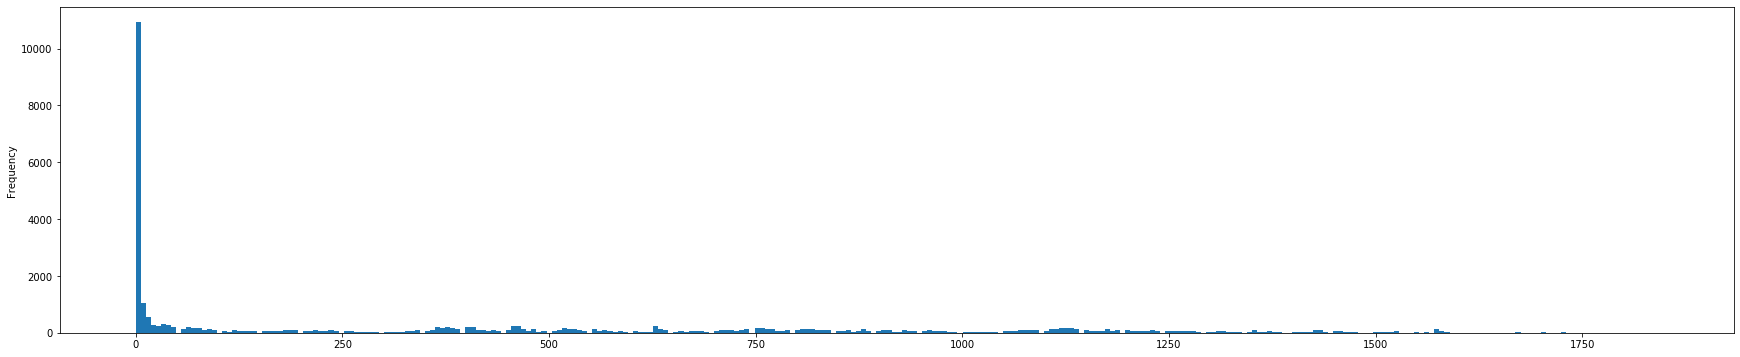

In [41]:
plt.figure(figsize=(30,6))
null_product.sort_values().plot('hist', bins=300)

In [145]:
train_cols = d_cols[-100:]

In [146]:
data_train = train_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']+train_cols]

In [147]:
null = data_train[train_cols].isnull().sum(axis=1)

In [148]:
null = null[null==0].index
data_train = data_train[data_train.id.isin(null)]

In [149]:
train_price = price_data.T
train_price= train_price[train_cols]

In [150]:
data_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1814,d_1815,d_1816,d_1817,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,2,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,3,2,4,3,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,1,0,0,...,2,1,1,0,1,1,2,2,2,4


In [151]:
calendar_data.head()

d,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
wday,1,2,3,4,5,6,7,1,2,3,...,7,1,2,3,4,5,6,7,1,2
month,1,1,1,2,2,2,2,2,2,2,...,6,6,6,6,6,6,6,6,6,6
snap_CA,0,0,0,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
snap_TX,0,0,0,1,0,1,0,1,1,1,...,0,1,1,1,0,1,0,0,0,0
snap_WI,0,0,0,0,1,1,0,1,1,0,...,0,1,1,0,1,1,0,0,0,0


In [152]:
train_price.head()

d,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_001_CA_1_validation,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,...,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
HOBBIES_1_002_CA_1_validation,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOBBIES_1_003_CA_1_validation,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,...,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97
HOBBIES_1_004_CA_1_validation,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,...,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64
HOBBIES_1_005_CA_1_validation,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88


In [153]:
data_train.store_id.value_counts()

TX_3    3049
TX_1    3049
WI_3    3049
TX_2    3048
CA_1    3048
WI_1    3048
CA_2    3047
CA_4    3047
WI_2    3046
CA_3    3046
Name: store_id, dtype: int64

In [154]:
data_train.state_id.value_counts()

CA    12188
TX     9146
WI     9143
Name: state_id, dtype: int64

In [211]:
#'snap_CA', 'snap_TX', 'snap_WI'
state='CA'

In [212]:
train_product = data_train[data_train.state_id==state]['id'].unique()

In [213]:
data = data_train.loc[train_product,train_cols]

In [214]:
data.head()

,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_001_CA_1_validation,0,0,0,2,1,2,1,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,3,2,4,3,1,2,3,0,8,2,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,0,1,0,0,0,1,0,0,3,0,...,2,1,1,0,1,1,2,2,2,4


In [215]:
calendar_index = [
    'wday', 'month', f'snap_{state}', 'Cultural_event_type_1', 'National_event_type_1', 'Religious_event_type_1',
    'Sporting_event_type_1', 'Cultural_event_type_2', 'National_event_type_2', 'Religious_event_type_2', 'Sporting_event_type_2'
]

calendar = calendar_data.loc[calendar_index,:]
event_index = [
    'Cultural_event_type_1', 'National_event_type_1', 'Religious_event_type_1', 'Sporting_event_type_1',
    'Cultural_event_type_2', 'National_event_type_2', 'Religious_event_type_2', 'Sporting_event_type_2'
]
for shift in [7, 14, 28, 56]:
    tmp_calendar = calendar.loc[event_index, :]
    tmp_calendar = tmp_calendar.T.shift(-shift).T
    tmp_calendar.index = [f'{col}_shift{shift}' for col in tmp_calendar.index]
    #tmp_calendar.columns = [f'{col}_shift{shift}' for col in tmp_calendar.columns]
    calendar = pd.concat([
        calendar,
        tmp_calendar
    ], axis=0)
calendar = calendar[train_cols]
calendar.head(20)

d,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
wday,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,...,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0
month,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
snap_CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cultural_event_type_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
National_event_type_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Religious_event_type_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sporting_event_type_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cultural_event_type_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
National_event_type_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Religious_event_type_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
price = price_data.T[train_cols].loc[train_product,:]
price_7 = price_data.loc[:,train_product].shift(-7).T[train_cols]
price_14 = price_data.loc[:,train_product].shift(-14).T[train_cols]
price_28 = price_data.loc[:,train_product].shift(-28).T[train_cols]
price_49 = price_data.loc[:,train_product].shift(-49).T[train_cols]

In [217]:
price_7.isnull().sum().sum(),price_14.isnull().sum().sum(),price_28.isnull().sum().sum(), price_49.isnull().sum().sum()

(0, 0, 0, 0)

In [218]:
price_7.head()

d,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_001_CA_1_validation,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,...,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
HOBBIES_1_002_CA_1_validation,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOBBIES_1_003_CA_1_validation,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,...,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97
HOBBIES_1_004_CA_1_validation,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,...,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64
HOBBIES_1_005_CA_1_validation,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88


In [219]:
data = torch.FloatTensor(data.values.astype(float))
calendar = torch.FloatTensor(calendar.values.astype(float))
price = torch.FloatTensor(price.values.astype(float))
price_7 = torch.FloatTensor(price_7.values.astype(float))
price_14 = torch.FloatTensor(price_14.values.astype(float))
price_28= torch.FloatTensor(price_28.values.astype(float))
price_49= torch.FloatTensor(price_49.values.astype(float))

In [220]:
labels = data[:,-28:]

In [221]:
labels

tensor([[ 1.,  0.,  0.,  ...,  0.,  1.,  1.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  0.,  0.,  ...,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  ...,  7.,  0.,  4.],
        [16.,  1.,  1.,  ...,  4.,  4.,  8.]])

In [222]:
calendar = calendar[:,:-28]

In [223]:
idx = 0

In [224]:
_data = data[[idx],:-28]
_price = price[[idx],:-28]
_price_7 = price_7[[idx],:-28]
_price_14 = price_14[[idx],:-28]
_price_28 = price_28[[idx],:-28]
_price_49 = price_49[[idx],:-28]
_label = labels[idx, :]
print(_data.size(), calendar.size(), _price.size(), _price_7.size(),_price_14.size(), _price_28.size(), _label.size(), _price_49.size())
x = torch.cat((_data, calendar, _price, _price_7, _price_14, _price_28, _price_49), dim=0)
x.size()

torch.Size([1, 72]) torch.Size([43, 72]) torch.Size([1, 72]) torch.Size([1, 72]) torch.Size([1, 72]) torch.Size([1, 72]) torch.Size([28]) torch.Size([1, 72])


torch.Size([49, 72])

In [225]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data, price, price_7, price_14, price_28, price_49, calendar, train = True):
        self.data = data
        self.price = price
        self.price_7 = price_7
        self.price_14 = price_14
        self.price_28 = price_28
        self.price_49 = price_49
        self.calendar = calendar
        self.datanum = len(data)
        self.train = train

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        _data = self.data[[idx],:-28]
        _price = self.price[[idx],:-28]
        _price_7 = self.price_7[[idx],:-28]
        _price_14 = self.price_14[[idx],:-28]
        _price_28 = self.price_28[[idx],:-28]
        x = torch.cat((_data, self.calendar, _price, _price_7, _price_14, _price_28), dim=0)
        if self.train:
            label = self.data[idx, -28:]
            return x, label
        else:
            return x

In [226]:
data_set=Mydatasets(data, price, price_7, price_14, price_28, price_49, calendar, train = True)
trainloader = torch.utils.data.DataLoader(data_set, batch_size = 100, shuffle = True)
a = 0
for x, y in tqdm(trainloader):
    if a<4:
        print(x.size(), y.size())
    a+=1

torch.Size([100, 48, 72]) torch.Size([100, 28])
torch.Size([100, 48, 72]) torch.Size([100, 28])
torch.Size([100, 48, 72]) torch.Size([100, 28])
torch.Size([100, 48, 72]) torch.Size([100, 28])



In [233]:
x.size()

torch.Size([88, 48, 72])

In [227]:
def mish(input):
    return input * torch.tanh(nn.functional.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

In [228]:
class residual_conv1d(nn.Module):

    def __init__(self, in_channel):
        super(residual_conv1d, self).__init__()
        
        self.mish = Mish()
        self.layer = nn.Sequential(
            nn.Conv1d(in_channel, in_channel, 1),
            Mish(),
            nn.Conv1d(in_channel, in_channel, 1)
        )

    def forward(self, x):
        x = x+self.layer(x)
        x = self.mish(x)
        return x

In [234]:
class Conv_1d_Net(nn.Module):

    def __init__(self, in_channel):
        super(Conv_1d_Net, self).__init__()
        
        self.layer_1 = nn.Sequential(
            nn.Conv1d(in_channel, 2*in_channel, 1),
            nn.Dropout(0.2),
            Mish(),
            residual_conv1d(2*in_channel)
        )
        
        self.layer_2 = nn.Sequential(
            nn.Conv1d(2*in_channel, 4*in_channel, 1),
            nn.Dropout(0.2),
            Mish(),
            residual_conv1d(4*in_channel)
        )
        
        self.layer_3 = nn.Sequential(
            nn.Conv1d(4*in_channel, 4*in_channel, 1),
            nn.Dropout(0.2),
            Mish(),
            residual_conv1d(4*in_channel)
        )
       
        self.layer_4 = nn.Sequential(
            nn.Conv1d(4*in_channel, 8*in_channel, 1),
            nn.Dropout(0.2),
            Mish(),
            residual_conv1d(8*in_channel)
        )
       
         
        self.avgpool1d = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(8*in_channel, 16*in_channel),
            nn.Dropout(0.1),
            Mish(),
            nn.Linear(16*in_channel, 32*in_channel),
            nn.Dropout(0.1),
            Mish(),
            nn.Linear(32*in_channel, 28),
            
            
            nn.ReLU()
        ) 

    def forward(self, x):
        #_in = x.size()[1]
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.avgpool1d(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [248]:
from torch.optim.optimizer import Optimizer
import math

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [249]:
def train_model(model, train_loader, test_loader):
    num_epochs = 40
    lr = 1e-4
    eta_min = 1e-3
    t_max = 10
    numclass = 5
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = RAdam(params=model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)


    best_epoch = -1

    for epoch in range(num_epochs):
        print('epoch', epoch)
        start_time = time.time()
        # change model to be train_mode 
        model.train()
        avg_loss = 0.
        #for x_batch, y_batch in progress_bar(train_loader, parent=mb):
        for x_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            preds = model(x_batch)
            loss = torch.sqrt(criterion(preds.squeeze(1), y_batch))
            
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            avg_loss += loss.item() / len(train_loader)

            
        # change model to be validation_mode
        model.eval()
        avg_val_loss = 0.

        for i, (x_batch, y_batch) in enumerate(test_loader):
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            #print('test')
            
            preds = model(x_batch)
            loss = torch.sqrt(criterion(preds.squeeze(1), y_batch))

            avg_val_loss += loss.item() / len(test_loader)

        if (epoch + 1) % 1 == 0:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f} time: {elapsed:.0f}s')
    
    
    torch.save(model.state_dict(), 'net.pt')
    
    return model

In [250]:
model = Conv_1d_Net(48)

In [251]:
model(x).size()
y.size()

torch.Size([88, 28])

In [237]:
trn_indx, val_indx = train_test_split([i for i in range(data.size()[0])], test_size=0.3)

In [238]:
#data = torch.log1p(data)

In [239]:
trn_data = data[trn_indx,:]
trn_price = price[trn_indx,:]
trn_price_7 = price_7[trn_indx,:]
trn_price_14 = price_14[trn_indx,:]
trn_price_28 = price_28[trn_indx,:]
trn_price_49 = price_49[trn_indx,:]


val_data = data[val_indx,:]
val_price = price[val_indx,:]
val_price_7 = price_7[val_indx,:]
val_price_14 = price_14[val_indx,:]
val_price_28 = price_28[val_indx,:]
val_price_49 = price_49[val_indx,:]

In [240]:
del data, price, price_14, price_28, price_49, price_7

In [241]:
gc.collect()

1340

In [252]:
model = Conv_1d_Net(48)

trn_data_set=Mydatasets(trn_data, trn_price, trn_price_7, trn_price_14, trn_price_28, trn_price_49, calendar, train = True)
trn_loader = torch.utils.data.DataLoader(trn_data_set, batch_size = 100, shuffle = True)

val_data_set=Mydatasets(val_data, val_price, val_price_7, val_price_14, val_price_28, val_price_49, calendar, train = True)
val_loader = torch.utils.data.DataLoader(val_data_set, batch_size = 50, shuffle = True)

In [253]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [254]:
gc.collect()

84

In [255]:
model = train_model(model, trn_loader, val_loader)

epoch 0



Epoch 1 - avg_train_loss: 3.4538  avg_val_loss: 2.8692 time: 5s
epoch 1



Epoch 2 - avg_train_loss: 2.4785  avg_val_loss: 2.2680 time: 5s
epoch 2



Epoch 3 - avg_train_loss: 2.3808  avg_val_loss: 2.1836 time: 5s
epoch 3



Epoch 4 - avg_train_loss: 2.2058  avg_val_loss: 2.1047 time: 5s
epoch 4



Epoch 5 - avg_train_loss: 2.1735  avg_val_loss: 2.3959 time: 5s
epoch 5



Epoch 6 - avg_train_loss: 2.1844  avg_val_loss: 2.1464 time: 5s
epoch 6



Epoch 7 - avg_train_loss: 2.3639  avg_val_loss: 2.1634 time: 5s
epoch 7



Epoch 8 - avg_train_loss: 2.2130  avg_val_loss: 2.1205 time: 5s
epoch 8



Epoch 9 - avg_train_loss: 2.1690  avg_val_loss: 2.3428 time: 5s
epoch 9



Epoch 10 - avg_train_loss: 2.1549  avg_val_loss: 2.1228 time: 5s
epoch 10



Epoch 11 - avg_train_loss: 2.2030  avg_val_loss: 2.1471 time: 5s
epoch 11



Epoch 12 - avg_train_loss: 2.2073  avg_val_loss: 2.1577 time: 5s
epoch 12



Epoch 13 - avg_train_loss: 2.2047  avg_val_loss: 2.1351 time: 5s
epoch 13



Epoch 14 - avg_train_loss: 2.1751  avg_val_loss: 2.1204 time: 5s
epoch 14



Epoch 15 - avg_train_loss: 2.1521  avg_val_loss: 2.1123 time: 5s
epoch 15



Epoch 16 - avg_train_loss: 2.1735  avg_val_loss: 2.2177 time: 5s
epoch 16



Epoch 17 - avg_train_loss: 2.1725  avg_val_loss: 2.1518 time: 5s
epoch 17



Epoch 18 - avg_train_loss: 2.1733  avg_val_loss: 2.1012 time: 5s
epoch 18



Epoch 19 - avg_train_loss: 2.1955  avg_val_loss: 2.1636 time: 5s
epoch 19



Epoch 20 - avg_train_loss: 2.1825  avg_val_loss: 2.1043 time: 5s
epoch 20



Epoch 21 - avg_train_loss: 2.1740  avg_val_loss: 2.1011 time: 5s
epoch 21



Epoch 22 - avg_train_loss: 2.1614  avg_val_loss: 2.1319 time: 5s
epoch 22



Epoch 23 - avg_train_loss: 2.1465  avg_val_loss: 2.1243 time: 5s
epoch 23



Epoch 24 - avg_train_loss: 2.1436  avg_val_loss: 2.0794 time: 5s
epoch 24



Epoch 25 - avg_train_loss: 2.1813  avg_val_loss: 2.1315 time: 5s
epoch 25



Epoch 26 - avg_train_loss: 2.1465  avg_val_loss: 2.1751 time: 5s
epoch 26



Epoch 27 - avg_train_loss: 2.1611  avg_val_loss: 2.1947 time: 5s
epoch 27



Epoch 28 - avg_train_loss: 2.1513  avg_val_loss: 2.1087 time: 5s
epoch 28



Epoch 29 - avg_train_loss: 2.1750  avg_val_loss: 2.1699 time: 5s
epoch 29



Epoch 30 - avg_train_loss: 2.1311  avg_val_loss: 2.0934 time: 5s
epoch 30



Epoch 31 - avg_train_loss: 2.1838  avg_val_loss: 2.0861 time: 5s
epoch 31



Epoch 32 - avg_train_loss: 2.1447  avg_val_loss: 2.2360 time: 5s
epoch 32



Epoch 33 - avg_train_loss: 2.1444  avg_val_loss: 2.1168 time: 5s
epoch 33



Epoch 34 - avg_train_loss: 2.1824  avg_val_loss: 2.0847 time: 5s
epoch 34



Epoch 35 - avg_train_loss: 2.1633  avg_val_loss: 2.2211 time: 5s
epoch 35



Epoch 36 - avg_train_loss: 2.2421  avg_val_loss: 2.0946 time: 5s
epoch 36



Epoch 37 - avg_train_loss: 2.1497  avg_val_loss: 2.0997 time: 5s
epoch 37



Epoch 38 - avg_train_loss: 2.1557  avg_val_loss: 2.1903 time: 5s
epoch 38



Epoch 39 - avg_train_loss: 2.1488  avg_val_loss: 2.1277 time: 5s
epoch 39



Epoch 40 - avg_train_loss: 2.1420  avg_val_loss: 2.1644 time: 5s


In [256]:
model = train_model(model, trn_loader, val_loader)

epoch 0



Epoch 1 - avg_train_loss: 2.1203  avg_val_loss: 2.1032 time: 5s
epoch 1



Epoch 2 - avg_train_loss: 2.1318  avg_val_loss: 2.1211 time: 5s
epoch 2



Epoch 3 - avg_train_loss: 2.0964  avg_val_loss: 2.1512 time: 5s
epoch 3



Epoch 4 - avg_train_loss: 2.1211  avg_val_loss: 2.1076 time: 5s
epoch 4



Epoch 5 - avg_train_loss: 2.1115  avg_val_loss: 2.1282 time: 5s
epoch 5



Epoch 6 - avg_train_loss: 2.1619  avg_val_loss: 2.1404 time: 5s
epoch 6



Epoch 7 - avg_train_loss: 2.1773  avg_val_loss: 2.1353 time: 5s
epoch 7



Epoch 8 - avg_train_loss: 2.1250  avg_val_loss: 2.1122 time: 5s
epoch 8



Epoch 9 - avg_train_loss: 2.1526  avg_val_loss: 2.1456 time: 5s
epoch 9



Epoch 10 - avg_train_loss: 2.1336  avg_val_loss: 2.1213 time: 5s
epoch 10



Epoch 11 - avg_train_loss: 2.1516  avg_val_loss: 2.1633 time: 5s
epoch 11



Epoch 12 - avg_train_loss: 2.1312  avg_val_loss: 2.1044 time: 5s
epoch 12



Epoch 13 - avg_train_loss: 2.1465  avg_val_loss: 2.1850 time: 5s
epoch 13



Epoch 14 - avg_train_loss: 2.1497  avg_val_loss: 2.1517 time: 5s
epoch 14



Epoch 15 - avg_train_loss: 2.1298  avg_val_loss: 2.0950 time: 5s
epoch 15



Epoch 16 - avg_train_loss: 2.1300  avg_val_loss: 2.1377 time: 5s
epoch 16



Epoch 17 - avg_train_loss: 2.1140  avg_val_loss: 2.0829 time: 5s
epoch 17



Epoch 18 - avg_train_loss: 2.1511  avg_val_loss: 2.1445 time: 5s
epoch 18



Epoch 19 - avg_train_loss: 2.1123  avg_val_loss: 2.1728 time: 5s
epoch 19



Epoch 20 - avg_train_loss: 2.1323  avg_val_loss: 2.1651 time: 5s
epoch 20



Epoch 21 - avg_train_loss: 2.1109  avg_val_loss: 2.0819 time: 5s
epoch 21



Epoch 22 - avg_train_loss: 2.1213  avg_val_loss: 2.2155 time: 5s
epoch 22



Epoch 23 - avg_train_loss: 2.1169  avg_val_loss: 2.1592 time: 5s
epoch 23



Epoch 24 - avg_train_loss: 2.1202  avg_val_loss: 2.1458 time: 5s
epoch 24



Epoch 25 - avg_train_loss: 2.1313  avg_val_loss: 2.1328 time: 5s
epoch 25



Epoch 26 - avg_train_loss: 2.1576  avg_val_loss: 2.1006 time: 5s
epoch 26



Epoch 27 - avg_train_loss: 2.1172  avg_val_loss: 2.1809 time: 5s
epoch 27



Epoch 28 - avg_train_loss: 2.1501  avg_val_loss: 2.1678 time: 5s
epoch 28



Epoch 29 - avg_train_loss: 2.1274  avg_val_loss: 2.1778 time: 5s
epoch 29



Epoch 30 - avg_train_loss: 2.1475  avg_val_loss: 2.2173 time: 5s
epoch 30



Epoch 31 - avg_train_loss: 2.1217  avg_val_loss: 2.1851 time: 5s
epoch 31



Epoch 32 - avg_train_loss: 2.1302  avg_val_loss: 2.0814 time: 5s
epoch 32



Epoch 33 - avg_train_loss: 2.1178  avg_val_loss: 2.2346 time: 5s
epoch 33



Epoch 34 - avg_train_loss: 2.1308  avg_val_loss: 2.2164 time: 5s
epoch 34



Epoch 35 - avg_train_loss: 2.1627  avg_val_loss: 2.1959 time: 5s
epoch 35



Epoch 36 - avg_train_loss: 2.1414  avg_val_loss: 2.1569 time: 5s
epoch 36



Epoch 37 - avg_train_loss: 2.1729  avg_val_loss: 2.1529 time: 5s
epoch 37



Epoch 38 - avg_train_loss: 2.1314  avg_val_loss: 2.1827 time: 5s
epoch 38



Epoch 39 - avg_train_loss: 2.1931  avg_val_loss: 2.1199 time: 5s
epoch 39



Epoch 40 - avg_train_loss: 2.1369  avg_val_loss: 2.1757 time: 5s
